In [16]:
import requests
import json
import sqlite3
import pandas as pd
from matplotlib import pyplot as plt

KEY = "518e72a11de080028921e78aba2a102c" 
URL_KEY = "&api_key=" + KEY + "&file_type=json"
URL_BASE = "https://api.stlouisfed.org/fred/"

ID_OBSERVATION = "MORTGAGE30US"
DB = "./database.db"

In [17]:
#Scaricare tutte le categorie a partire da una categoria data 
#(la struttura è ad albero e la categoria root ha id=0)

def get(url_base, url_key, type, id):
    
    if type == "category": url = url_base + "category?category_id=" + str(id) + url_key
    
    elif type == "series": url = url_base + "category/series?category_id=" + str(id) + url_key
    
    elif type == "observation": url = url_base + "series/observations?series_id=" + id + url_key
    
    try:
        
        request = requests.get(url)
        check = r.status_code
    
        if check != 200:
        
            print("Wrong request\n")
            exit()
    
    except requests.ConnectionError:
        
        print("No internet connection\n")
        exit()
        
    return request

r = get(URL_BASE, URL_KEY, "observation", ID_OBSERVATION)
#print(json.dumps(r.json(), indent=4))

In [30]:
#Insieme di funzioni per interagire con SQLite

def connect_db(db_file):
    
    connection = None
    try:
        connection = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    finally:
        return connection
    
def create_db(db_file):
    
    connection = connect_db(db_file)
    cursor = connection.cursor()
        
    #Tabella delle serie scaricate e/o analizzate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS seriess
       ([id] TEXT PRIMARY KEY, [title] TEXT)
       ''')
        
    #Tabella con le osservabili delle serie scaricate e/o analizzate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS observations
       ([date] TEXT, [id] TEXT, [value] TEXT, PRIMARY KEY (date, id))
       ''')
        
    #Tabella con l’elenco delle serie scaricate
    cursor.execute('''
       CREATE TABLE IF NOT EXISTS seriess_downloaded
       ([id] TEXT PRIMARY KEY, [title] TEXT)
       ''')
        
    connection.commit()
    connection.close()

def insert_db(db_file, id, type):

    connection = connect_db(db_file)
    cursor = connection.cursor()
    
    if type == "observations":
        
        json = get(URL_BASE, URL_KEY, "observation", id)
        observations = json.json()["observations"]
        lenght = len(observations)
        
        query_check = ''' SELECT count(*) FROM observations WHERE date = (?) AND id = (?) '''
        query = ''' INSERT INTO observations (date, id, value) VALUES (?,?,?) '''

    
    elif type == "seriess":
        
        json = get(URL_BASE, URL_KEY, "series", id) #get_serie(URL_BASE, URL_KEY, 3)
        series = json.json()["seriess"]
        lenght = len(series)
        
        query_check = ''' SELECT count(*) FROM seriess WHERE id = (?) '''
        query_download = ''' INSERT INTO seriess_downloaded (id, title) VALUES (?,?) ''' 
        query = ''' INSERT INTO seriess (id, title) VALUES (?,?) '''

        
    for index in range(lenght):
        
        if type == "observations":
        
            observation = observations[index]

            #controlla se (date,id) è già presente, in caso ignora la insert
            params = observation["date"], id
            cursor.execute(query_check, params)

            check = cursor.fetchone()[0]
            if check != 0:
                continue

            #se (date,id) non presente, è inserita la relativa row
            params = observation["date"], id, observation["value"]
            cursor.execute(query, params)

        elif type == "seriess":
            
            serie = series[index]
            
            #controlla se id della serie già presente, in caso ignora la insert
            params = series[index]["id"],
            cursor.execute(query_check, params)
            
            check = cursor.fetchone()[0]
            if check != 0:
                continue
                
            #se id non presente, è inserita la relativa row
            params = series[index]["id"], series[index]["title"]
            cursor.execute(query, params)
            cursor.execute(query_download, params)
                        
        connection.commit()
             
    connection.close()

def get_db(db_file, type, id):
    
    connection = connect_db(db_file)
    cursor = connection.cursor()
    
    if type == "seriess":
        
        cursor.execute(''' SELECT s.id, s.title FROM seriess s ''')
        df = pd.DataFrame(cursor.fetchall(), columns=['id','title'])
        
    elif type == "seriess_downloaded":
        
        cursor.execute(''' SELECT s.id, s.title FROM seriess_downloaded s ''')
        df = pd.DataFrame(cursor.fetchall(), columns=['id','title'])
    
    elif type == "observations":
        
        query = ''' SELECT o.date, o.id, o.value FROM observations o WHERE o.id = (?) '''
        params = id,
        cursor.execute(query, params)
        df = pd.DataFrame(cursor.fetchall(), columns=['date', 'id', 'value'])
    
    connection.close()
    return df
       
#create_db(DB)

insert_db(DB, 3, "seriess")
insert_db(DB, "T10Y2Y", "observations")

df = get_db(DB, "observations", "T10Y2Y")
print(df)

df = get_db(DB, "seriess_downloaded", 0)
#print(df)

             date      id value
0      1976-06-01  T10Y2Y  0.68
1      1976-06-02  T10Y2Y  0.71
2      1976-06-03  T10Y2Y  0.70
3      1976-06-04  T10Y2Y  0.77
4      1976-06-07  T10Y2Y  0.79
...           ...     ...   ...
11904  2022-01-17  T10Y2Y     .
11905  2022-01-18  T10Y2Y  0.81
11906  2022-01-19  T10Y2Y  0.79
11907  2022-01-20  T10Y2Y  0.75
11908  2022-01-21  T10Y2Y  0.74

[11909 rows x 3 columns]


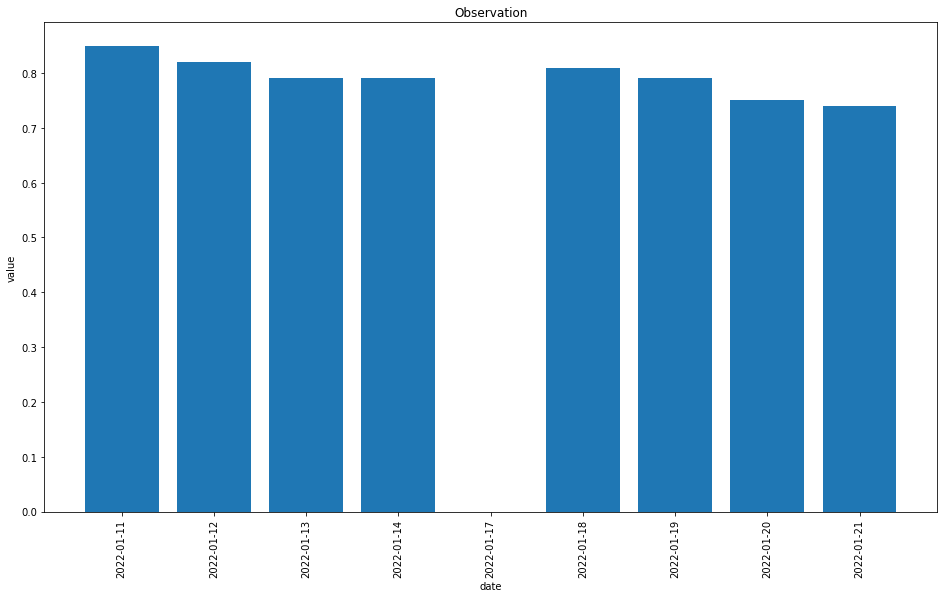

In [33]:
#Graficare l’andamento di una osservabile (se possibile)

def convert_string_float(array_string):
    
    array_float = []
    
    for values in array_string:
    
        if values == ".": values = "0"
    
        array_float.append(float(values))
    
    return array_float

def show():
    
    pd = get_db(DB, "observations", "T10Y2Y")
    y = pd['date'].tolist()
    x = pd['value'].tolist()
    
    z = convert_string_float(x)    
    
    plt.figure(figsize=(16,9)) 
    plt.bar(y[11900:11909], z[11900:11909])
    plt.ylabel("value") 
    plt.xlabel("date") 
    plt.xticks(rotation=90)
    plt.title("Observation") 
    plt.show()

show()

#Graficare la media mobile (se possibile) di una osservabile a 𝑛 giorni (𝑛 parametro)
def media_mobile(vett, n):
    ret = []
    finestra = 0
    
    for i in range(n):
        finestra += vett[i]
        
    for i in range(n, len(vett)):
        ret.append(finestra / n)
        finestra = finestra + vett[i] - vett[i-n]
    
    return ret
        
#m = media_mobile(z, 7)
#plt.figure(figsize=(16, 9))
#plt.title("Media mobile") 
#plt.plot(m)